# Tarefa 
Esse notebook contém o desenvolvimento da análise para o case prático do processo seletivo para estagiário de dados na Passei direto. O enunciado do problema é o seguinte:

"Você deverá preparar uma apresentação descrevendo o perfil dos usuários da Passei Direto.
Dentre as informações, deverá falar sobre:
- Qual é o perfil do usuário que mais utiliza a plataforma;
- Qual é o perfil predominante do usuário que assina (é pagante) a plataforma."



Autor: Marcos Bonfim Mansur

Blog: https://medium.com/@mmansur

Git: https://github.com/marcos-mansur


# Carregar libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif

#from sklearn.externals import joblib
import os

import warnings
warnings.filterwarnings("ignore")


# Funções

In [2]:
# setup bonito de azul para gráficos
colors = ['#06344d', '#00b2ff']
sns.set(palette = colors, font = 'Serif', style = 'white', 
        rc = {'axes.facecolor':'#f1f1f1', 'figure.facecolor':'#f1f1f1'})

In [3]:
# colunas que não carregam informação
bad_cols = ['Userid']
# variáveis categóricas
cat_var = ['Curso','Universidade']
# variáveis numéricas
num_var = ['Acessos no Mês',
           'Arquivos Visualizados no Mês', 
           'Semestre Atual',
           'Semestre Total']
# variável de interesse
target = 'Usuário Pagante?'
# sigla de Arquivos Visualizados no Mês
avm = 'Arquivos Visualizados no Mês'
# sigla de Acessos no Mês
acm = 'Acessos no Mês'
# variáveis de acesso
acc_var = [avm,acm]
# random seed
seed = 42

In [4]:
class feat_eng(BaseEstimator,TransformerMixin):
  "adiciona colunas"
  def __init__(self,cursando=True):
    self.cursando=cursando
    pass

  def fit(self,x,y=None):
    return self
  
  def transform(self,x,y=None):
    df1=x.copy()
    if self.cursando:
      df1['% cursando'] = df1['Semestre Atual']/df1['Semestre Total']*100
    
    return df1

def func_sigla_uni(df):
  "Substitui o nome da Universidade pela sigla"
  df_uni=df.copy()
  # pega apenas a primeira palavra da universidade, nesse caso, a sigla
  df_uni['Universidade'] = df_uni['Universidade'].apply(lambda x: x.split()[0])
  return df_uni
# FunctionTransformer para ser usado em pipeline
sigla_uni = FunctionTransformer(func_sigla_uni)

def f_map_cluster(df):
  df_cluster = df.copy()
  df_cluster['Cluster'] = df_cluster['Cluster'].map({0:'Heavy User', 1:'User'})
  return df_cluster
# FunctionTransformer para ser usado em pipeline
map_cluster = FunctionTransformer(f_map_cluster)

# pipeline de preprocessamento
pp_pipe = make_pipeline(sigla_uni,feat_eng())

In [5]:
def user_perfil(df_cluster,var, hue, hue_cond,figsize=(15,7), titulo='Heavy User'):
  """gera análise de perfil para a variável 'var' definida"""

  df_aux2 = df_cluster[df_cluster[hue]==hue_cond].copy()
  print(f'Quanto % dos {titulo}s são de cada curso: \n'
        + f"{np.round(df_aux2.groupby([var])['Userid'].count()/len(df_aux2)*100,2)}")
  print(f'\nQuanto % de cada curso é {titulo}: \n'
        + f"{np.round(df_aux2.groupby([var])['Userid'].count()/func_sigla_uni(df).groupby([var])['Userid'].count(),2)*100}")

  # paleta para gráfico de pizza
  colors1 = ['#00B2FF','#004F70','#00A8F0','#00B1FC','#0096D6','#00B2FF','#004F70','#00A8F0','#00B1FC','#0096D6']
  # dados de quanto % dos Heavy users são de cada curso
  data_pie = np.round(df_aux2.groupby([var])['Userid'].count()/len(df_aux2)*100,2)
  # gráfico de pizza (pie chart)
  explode = [0.1 for x in range(len(data_pie))]

  # figura
  _,ax=plt.subplots(figsize=figsize, ncols=2)
  # plota pie chart
  ax[0].pie(data_pie, labels = data_pie.index, explode=explode,autopct='%1.1f%%', colors=colors1)
  ax[0].set_title(f'% de cada {var} dos {titulo}s', size=20)

  # plota histograma
  sns.histplot(x=df_cluster[var], ax=ax[1], hue=df_cluster[hue], color=colors, multiple='stack')
  # inclina a legenda do histograma
  ax[1].tick_params(axis='x', rotation=20)

  data_count = df_aux2.groupby([var])['Userid'].count()
  data_bar = np.round(df_aux2.groupby([var])['Userid'].count()/func_sigla_uni(df).groupby([var])['Userid'].count(),2)*100
  c=0
  for curso, count in zip(data_bar,data_count):
    ax[1].text(x = c, y = count,
                    s = f'{curso}%', 
                    ha = 'center', size = 12, weight = 'bold', rotation = 0, color = 'white',
                    bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
    c+=1
  ax[1].set_title(f'Quanto % de cada {var} é {titulo} - barras empilhadas', size=15, weight='bold')
  plt.show()


def plot_hist(df, col_plot,nrows=2,ncols=2,figsize=(15,15), kde=True, rota=0,hue=target):
  """
  Plota histogramas das colunas selecionadas do dataset.
  
  df = dataset com os dados a serem plotados no formato pd.DataFrame
  col_plot = colunas a serem plotadas
  kde = plota uma estimativa de densidade kernel, uma suavização da distribuição
  """         
  # cria as figuras dos gráficos
  fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
  # loop entre as figuras e as colunas a serem plotadas 
  for axis,col in zip(ax.ravel(),col_plot):
    # define a quantidade de bins no histograma como automático
    bins='auto'
    # os dados de 'Semestre Atual' e '% concluídos' ficam melhores com 10 bins 
    if col == 'Semestre Atual':
      bins = 10
    if col == '% cursando':
      bins=8
    if col == 'Semestre Total':
      bins= 3
    # plota um histograma
    sns.histplot(data=df, x=df[col],ax = axis, bins=bins, hue=hue,kde=kde)
    # título do gráfico
    axis.set_title(f'Histograma de "{col}"', size=15, weight ='bold')
    axis.tick_params(axis='x', rotation=rota)
    plt.tight_layout()

  plt.show()

def plot_1hist(df, col, bins='auto', kde=True, figsize=(10,7), hue=target):
  """facilita plotar 1 histograma"""
  fig,ax = plt.subplots(figsize=figsize)
  sns.histplot(data=df, x=df[col],ax = ax, bins=bins, hue=hue,kde=kde)
  # título do gráfico
  ax.set_title(f'Histograma de "{col}"', size=15, weight ='bold')
  ax.tick_params(axis='x', rotation=10)
  plt.tight_layout()
  plt.show()
  return ax

# Carregar dados

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/',
                              'Data Science/Analysis/PS Passei Direto/',
                              'Dataset - CASE Analise de Dados - Dados.csv'))

# substitui "Sim" e "Não" da coluna "Usuário Pagante?" por 1 e 0, respectivamente
df['Usuário Pagante?'] = df['Usuário Pagante?'].map({'Sim':1,'Não':0})

In [6]:
df.head()

,Userid,Acessos no Mês,Arquivos Visualizados no Mês,Universidade,Curso,Usuário Pagante?,Semestre Atual,Semestre Total
0,3508,5,0,UFMG - Universidade Federal de Minas Gerais,Administração,0,4,8
1,3560,11,0,UFMG - Universidade Federal de Minas Gerais,Administração,0,6,8
2,3552,11,1,UFMG - Universidade Federal de Minas Gerais,Administração,1,4,8
3,3425,1,3,UFMG - Universidade Federal de Minas Gerais,Administração,0,1,8
4,3452,16,4,UFMG - Universidade Federal de Minas Gerais,Administração,0,1,8


# Análise Exploratória dos Dados

## Conhecer as colunas do dataset

e seus formatos (int, object, float, etc), o que cada variável significa e quais são numéricas e quais categóricas


As colunas e suas descrições são as seguintes: 

- userid: É a coluna de ID único que representa cada usuário;
- Acessos no Mês: a quantidade de dias distintos que o usuário fez login na plataforma;
- Arquivos Visualizados: a quantidade de arquivos que o usuário visualizou durante o mês;
- Universidade: o nome da universidade onde o usuário realiza a sua graduação;
- Curso: o nome do curso de graduação do usuário;
- Usuário Pagante?: informa se o usuário é um assinante da plataforma (caso Sim) ou se o usuário utiliza uma conta Free (caso Não);
- Semestre Atual: o semestre que o usuário está cursando no mês atual;
- Semestre Total: a quantidade total de semestres do curso do usuário.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Userid                        999 non-null    int64 
 1   Acessos no Mês                999 non-null    int64 
 2   Arquivos Visualizados no Mês  999 non-null    int64 
 3   Universidade                  999 non-null    object
 4   Curso                         999 non-null    object
 5   Usuário Pagante?              999 non-null    int64 
 6   Semestre Atual                999 non-null    int64 
 7   Semestre Total                999 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 62.6+ KB


In [8]:
df[[target]+num_var].describe()

,Usuário Pagante?,Acessos no Mês,Arquivos Visualizados no Mês,Semestre Atual,Semestre Total
count,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.333333,11.221221,37.153153,4.672673,8.282282
std,0.471641,7.320197,23.419490,2.379346,0.696683
min,0.000000,1.000000,0.000000,1.000000,8.000000
25%,0.000000,5.000000,17.500000,3.000000,8.000000
50%,0.000000,10.000000,37.000000,5.000000,8.000000
75%,1.000000,16.000000,53.000000,7.000000,8.000000
max,1.000000,30.000000,100.000000,10.000000,10.000000


In [ ]:
df.nunique()

Userid                          999
Acessos no Mês                   30
Arquivos Visualizados no Mês    100
Universidade                      4
Curso                             5
Usuário Pagante?                  2
Semestre Atual                   10
Semestre Total                    2
dtype: int64

## Distribuição das variáveis numéricas

In [9]:
df1 = df.drop('Userid', axis=1).copy()

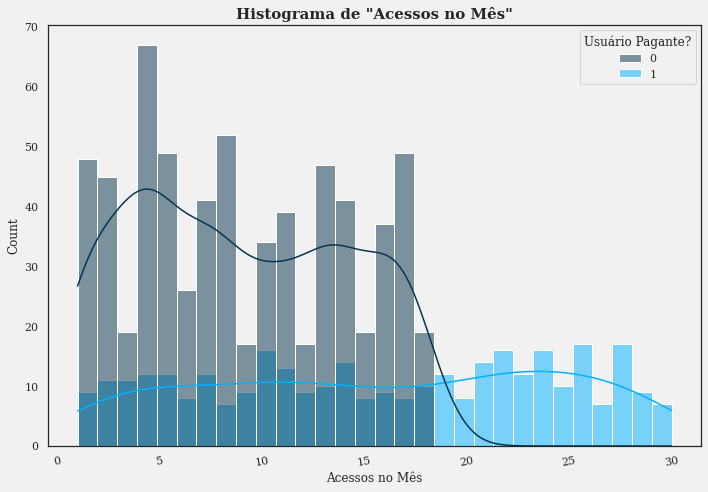

In [10]:
col = 'Acessos no Mês'
bins = 30
hue = target
kde = True
figsize=(10,7)
fig,ax = plt.subplots(figsize=figsize)
sns.histplot(data=df1, x=df1[col],ax = ax, bins=bins, hue=hue,kde=kde)
# título do gráfico
ax.set_title(f'Histograma de "{col}"', size=15, weight ='bold')
ax.tick_params(axis='x', rotation=10)
plt.tight_layout()
plt.show()

Nos acessos por mês, podemos ver pelo menos 2 patamares de frequência bem definidos. Esses são potenciais agrupamentos de usuário por patamar de acesso no mês. Além disso, no banco de dados fornecido, apenas usuários pagantes acessaram a plataforma mais de 18 dias por mês.

In [15]:
print(f"Media de Acessos no Mês em todo o dataset: {np.round(df['Acessos no Mês'].mean(),2)} dias")
print(f'Usuários com mais de 18 acessos em dias distintos no mês correspondem a',
      f"{np.round(df[df['Acessos no Mês']>18].shape[0]/len(df)*100,2)}%",
      f"dos usuários \ndo dataset.")

Media de Acessos no Mês em todo o dataset: 11.22 dias
Usuários com mais de 18 acessos em dias distintos no mês correspondem a 14.51% dos usuários 
do dataset.


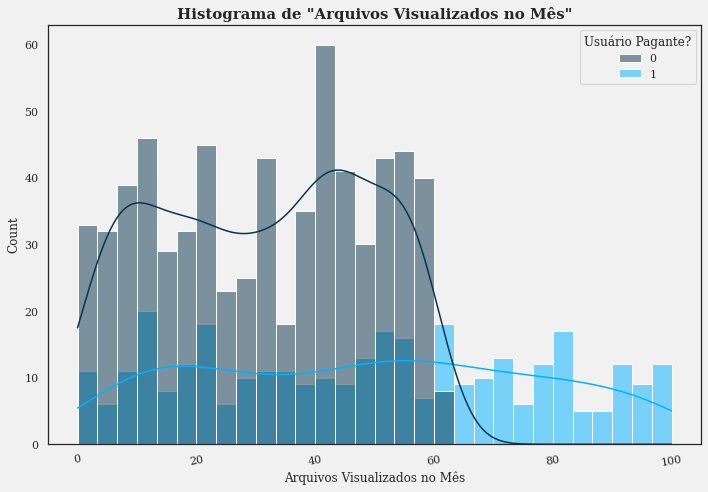

In [ ]:
col = 'Arquivos Visualizados no Mês'
bins = 30
hue = target
kde = True
figsize=(10,7)
fig,ax = plt.subplots(figsize=figsize)
sns.histplot(data=df1, x=df1[col],ax = ax, bins=bins, hue=hue,kde=kde)
# título do gráfico
ax.set_title(f'Histograma de "{col}"', size=15, weight ='bold')
ax.tick_params(axis='x', rotation=10)
plt.tight_layout()
plt.show()

In [11]:
# apenas a sigla das universidades e cria coluna "% cursando"
df_avm = pp_pipe.fit_transform(df)

In [14]:
print(f'Usuários com 60 ou mais arquivos visualizados no mês correspondem a',
      f"{np.round(df[df[avm]>=60].shape[0]/len(df)*100,2)}% do dataset \ne",
      f"são responsáveis por {np.round(df[df[avm]>=60][avm].sum()/df[avm].sum()*100,2)}%",
      f"dos arquivos visualizados. Além disso,"
      f" em média acessam \na plataforma em {np.round(df[df[avm]>=60]['Acessos no Mês'].mean(),2)}",
      f"dos 30 dias do mês")

Usuários com 60 ou mais arquivos visualizados no mês correspondem a 13.61% do dataset 
e são responsáveis por 28.48% dos arquivos visualizados. Além disso, em média acessam 
a plataforma em 14.82 dos 30 dias do mês


Para os arquivos vizualizados no mês, apenas assinantes acessaram mais de 60 arquivos, com queda abrupta de usuários nesse limite, formando dois patamares visivelmentes distinguíveis. Também são potenciais agrupamentos de usuário por patamar de arquivos visualizados no mês.

Atualmente, a Passei Direto limita acesso a 5 arquivos por mês para não assinantes. Aqui, estamos assumindo que o usuário pagante e não pagante tem o mesmo acesso à plataforma, sem limitações. Caso contrário, é possível  que o limite de 60 arquivos visto nos dados ative uma pay-wall definida pela plataforma.

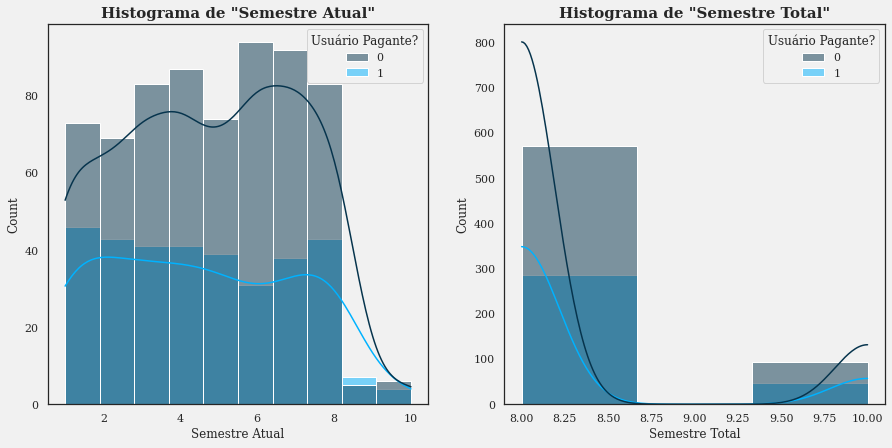

In [ ]:
# plota histogramas
plot_hist(df1, num_var[2:], nrows=1, figsize=(15,7))

Olhando para os gráficos de "Semestre Atual" e "Semestre Total", vemos que a grande maioria dos usuários estão entre o primeiro e oitavo período e que a maioria da base é consitituída por usuários de cursos de 8 semestres totais. Vamos estudar melhor essa relação.

In [ ]:
# conta o número de amostras agrupagas por curso e quantos semestres tem o curso
df1.groupby(['Curso'])['Semestre Total'].value_counts()

Curso            Semestre Total
Administração    8                 300
Direito          8                 249
Educação Física  8                 147
Medicina         10                141
Pedagogia        8                 162
Name: Semestre Total, dtype: int64

Os cursos de medicina tem 10 períodos e os demais tem 8.

Para comparar os cursos com semestre total diferentes, criamos uma variável "% cursando" que quantifica o progresso do usuário na faculdade. 100% significa estar cursando o último período.

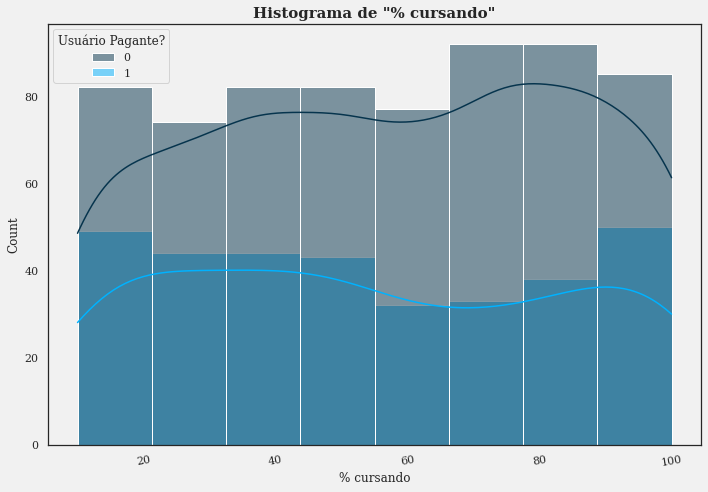

In [145]:
col = '% cursando'
bins = 8
hue = target
kde = True
figsize=(10,7)
fig,ax = plt.subplots(figsize=figsize)
sns.histplot(data=df_avm, x=df_avm[col],ax = ax, bins=bins, hue=hue,kde=kde)
# título do gráfico
ax.set_title(f'Histograma de "{col}"', size=15, weight ='bold')
ax.tick_params(axis='x', rotation=10)
plt.tight_layout()
plt.show()

In [102]:
df_3 = df_avm[df_avm['Curso'] != 'Medicina'][df_avm['Semestre Atual']>=6].copy()
df_4 = df_avm[df_avm['Curso'] == 'Medicina'][df_avm['Semestre Atual']>=8].copy()
soma1=len(df_3)+len(df_4)
print(f"Alunos nos últimos 3 períodos são {np.round(soma1/len(df)*100,2)}% do dataset")

Alunos nos últimos 3 períodos são 37.74% do dataset


Maior ocorrência de usuários no fim do curso, último terço.

## 4. Distribuição e cardinalidade das variáveis categóricas
e labels raros

Vamos olhar para  a distribuição das variáveis categóricas `Curso`, `Universidade` e `Usuário Pagante?`. 

Os cículos mostram em quanto do dataset total cada categoria ocorre.

In [12]:
# cria uma cópia do df1
df_uni = sigla_uni.fit_transform(df)

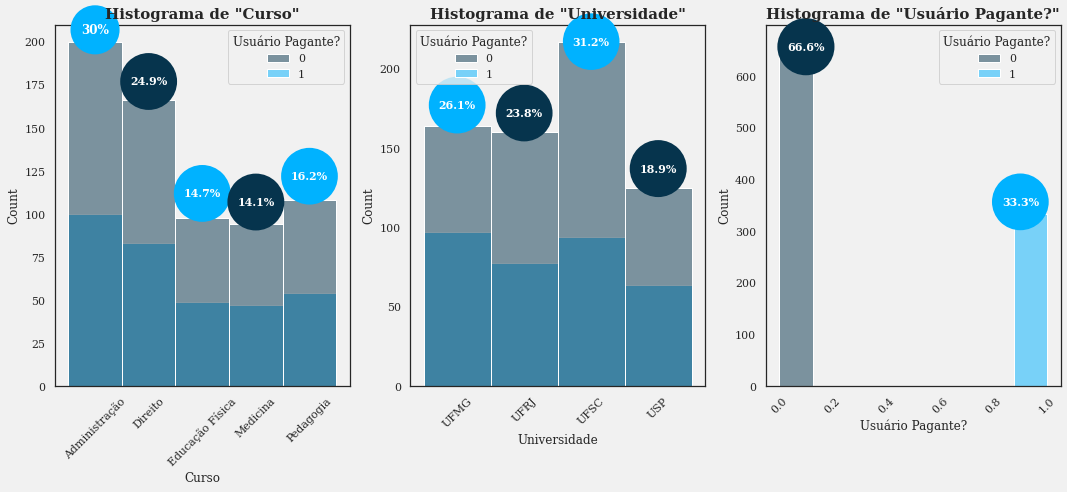

In [53]:
nrows=1
ncols=3
figsize=(15,7)
col_plot = ['Curso', 'Universidade', 'Usuário Pagante?']
bins=8
hue=target
kde=False
rota=45

fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
# loop entre as figuras e as colunas a serem plotadas 
for axis,col in zip(ax.ravel(),col_plot):
  # plota um histograma
  sns.histplot(data=df_avm, x=df_avm[col],ax = axis, bins=bins, hue=hue,kde=kde)
  # título do gráfico
  axis.set_title(f'Histograma de "{col}"', size=15, weight ='bold')
  axis.tick_params(axis='x', rotation=rota)
  plt.tight_layout()

size = 11
# plot 1:  
# balão % de adm
ax.ravel()[0].text(x = 0, y = 205,
                  s = '30%', 
                  ha = 'center', size =size+1, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
# balão % de direito
ax.ravel()[0].text(x = 1, y = 175,
                  s = '24.9%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))
# balão % de EdFis
ax.ravel()[0].text(x = 2, y = 110,
                  s = '14.7%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
# balão % de Med
ax.ravel()[0].text(x = 3, y = 105,
                  s = '14.1%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))
# balão % de Pedagogia
ax.ravel()[0].text(x = 4, y = 120,
                  s = '16.2%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))

#plot 2
# balão % de UFMG
ax.ravel()[1].text(x = 0, y = 175,
                  s = '26.1%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
# balão % de UFRJ
ax.ravel()[1].text(x = 1, y = 170,
                  s = '23.8%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))
# balão % de UFSC
ax.ravel()[1].text(x = 2, y = 215,
                  s = '31.2%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
# balão % de USP
ax.ravel()[1].text(x = 3, y = 135,
                  s = '18.9%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))

#plot 3:
# balão % de Pagante
ax.ravel()[2].text(x = 0.1, y = 650,
                  s = '66.6%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))
# balão % de não Pagante
ax.ravel()[2].text(x = 0.9, y = 350,
                  s = '33.3%', 
                  ha = 'center', size = size, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))


plt.show()

Tanto o curso quanto a universidade não aparentam, a primeira vista, serem discriminantes para a assinatura. 

In [16]:
print(f'% de ocorrência de cada curso no Dataset: \n'
      + f"{np.round(df.groupby(['Curso'])['Userid'].count()/len(df)*100,2)}")

print(f'\n% de ocorrência de cada Universidade no Dataset: \n'
      + f"{np.round(df.groupby(['Universidade'])['Userid'].count()/len(df)*100,2)}")

print(f'\n% de ocorrência de usuários pagantes e não pagantes: \n'
      + f"{np.round(df.groupby([target])['Userid'].count()/len(df)*100,2)}")

% de ocorrência de cada curso no Dataset: 
Curso
Administração      30.03
Direito            24.92
Educação Física    14.71
Medicina           14.11
Pedagogia          16.22
Name: Userid, dtype: float64

% de ocorrência de cada Universidade no Dataset: 
Universidade
UFMG - Universidade Federal de Minas Gerais      26.13
UFRJ - Universidade Federal do Rio de Janeiro    23.82
UFSC - Universidade Federal de Santa Catarina    31.13
USP - Universidade de São Paulo                  18.92
Name: Userid, dtype: float64

% de ocorrência de usuários pagantes e não pagantes: 
Usuário Pagante?
0    66.67
1    33.33
Name: Userid, dtype: float64


## Correlação

Para calcular a correlação, vamos primeiro analisar o Boxplot das variáveis numéricas para garantir que não haverão outliers que podem impactar o cálculo de correlação linear:

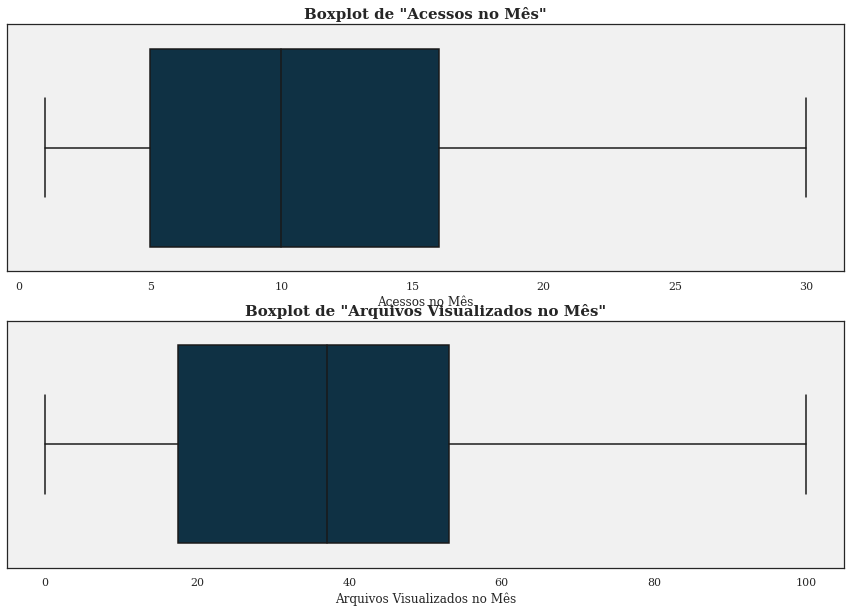

In [17]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
  # loop entre as figuras e as colunas a serem plotadas 
for axis,col in zip(ax.ravel(),acc):
  # plota um histograma
  sns.boxplot(data=df, x=df[col],ax = axis)
  # título do gráfico
  axis.set_title(f'Boxplot de "{col}"', size=15, weight ='bold')

Pela análise do boxplot, não identificamos outlier nas duas variáveis estudadas. 

#### Coeficiente de Pearson

Primeiro, vamos entender as correlações lineares das variáveis numéricas através do coeficiente de Pearson.

O coeficiente de Pearson mede o grau de relação linear entre variáveis numéricas contínuas e varia de -1 a 1, sendo -1 uma relação linear inversa e 1 uma relação de proporcionalidade direta.

In [ ]:
!pip install feature_engine

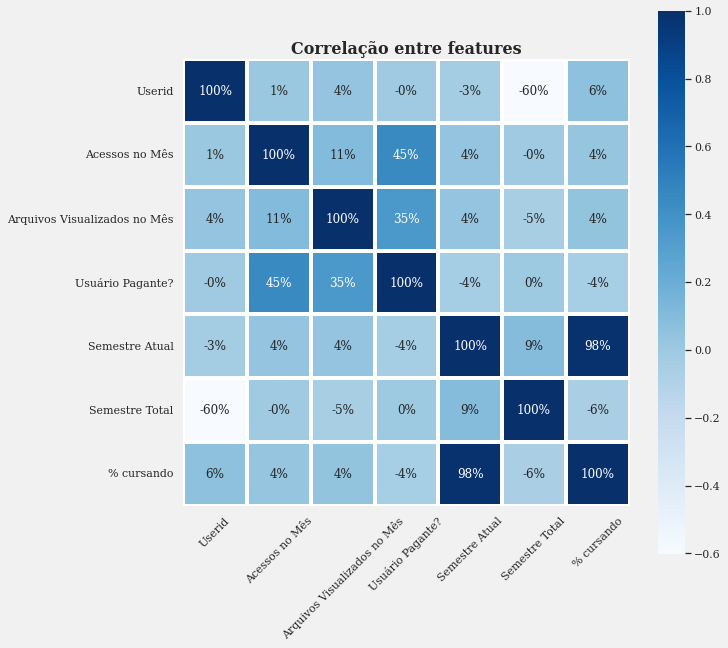

In [23]:
# cria a figura do gráfico
fig,ax = plt.subplots(figsize=(10,10))
# seleciona variáveis categóricas
df_aux = pp_pipe.fit_transform(df)

# plota heatmap de correlação
sns.heatmap(df_aux.corr(method='pearson'), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%", ax=ax)
ax.set_title('Correlação entre features', fontsize=16, weight='bold', y=1.05);
ax.set_xticklabels(df_aux.columns, fontsize=12, rotation=0, minor=True)
ax.set_yticklabels(df_aux.columns, fontsize=12, rotation=0, minor=True)
ax.tick_params(axis='x', rotation=45)

As correlações mais expressivas são de acessos no mês e arquivos visualizados no mês com `Usuário Pagante?`.

A correlação entre Curso, Semestre Total e % cursando também é esperada.

#### Coeficiente de Spearman

O coeficiente de correlação de postos de Spearman é semelhante ao coeficiente de Pearson, porém, enquanto o primeiro mede a relação linear entre dados o coeficiente de spearman considera a ordem dos dados (posição relativa das observações no interior da variável, exp.: 1º, 2º, 3º) para mensurar quanto o comportamento de uma variável pode ser descrito por outra variável através de uma função monótona.

Agora, vamos analisar as correlações lineares das variáveis categóricas através do método de Spearman. Dessa maneira, considera-se o rank da amostra no conjunto, e não seu valor, sendo mais indicado para comparar variáveis categóricas.

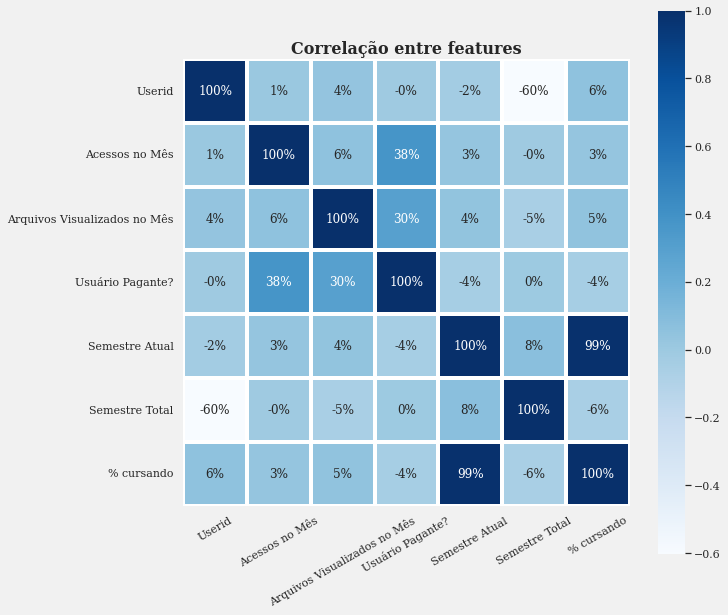

In [24]:
# cria a figura do gráfico
fig,ax = plt.subplots(figsize=(10,10))
# plota heatmap de correlação
sns.heatmap(df_aux.corr(method='spearman'), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%", ax=ax)
ax.set_title('Correlação entre features', fontsize=16, weight='bold', y=1.05);
ax.set_xticklabels(df_aux.columns, fontsize=12, rotation=0, minor=True)
ax.set_yticklabels(df_aux.columns, fontsize=12, rotation=0, minor=True);
ax.tick_params(axis='x', rotation=30)


Sem grandes diferenças para a correlação de Pearson.

# Qual é o perfil do usuário que mais utiliza a plataforma;

Primeiro, precisamos definir os critérios para quantificar quem utiliza mais a plataforma. Podemos considerar os arquivos vizualizados no mês, o número de dias acessados no mês ou uma combinação desses.

## Critério de quem mais utiliza - Clusters por KMeans

Para definir os usuários que mais utilizam a plataforma, vamos criar clusters com base nas variáveis "Acessos no Mês" e "Arquivos Vizualizados no Mês".

O stripplot é uma versão do gráfico de dispersão que possibilita visualizar variáveis categóricas melhor. Abaixo, vemos o plot dos usuários pelas duas variáveis mensionadas acima.

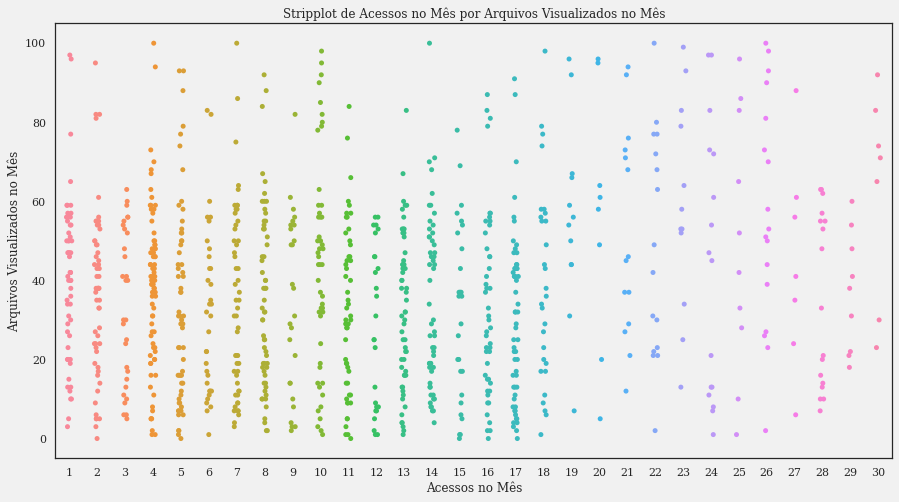

In [142]:
fig,ax=plt.subplots(figsize=(15,8))
sns.stripplot(x=df['Acessos no Mês'],y=df['Arquivos Visualizados no Mês'], hue=None,)
ax.set_title('Stripplot de Acessos no Mês por Arquivos Visualizados no Mês')
plt.show()

Para definir quais usuários são heavy users, usaremos o algoritmo de KMeans para criar clusters a partir das variáveis relacionadas a acesso, que são `Arquivos Visualizados no Mês` e `Acessos no Mês`.

KMeans inicia centróides para o número de clusters definidos, calcula a distância de cada amostra ao centróide mais próximo e move os centróides visando minimizar a soma dos quadrados das distâncias de cada amostra ao centróide mais próximo, agrupando os dados por proximidade.

Para definir o número de clusters, podemos usar o método do cotovelo mas a experimentação para encontrar o agrupamento que melhor representa heavy users também entre em questão, assim como experimentar outros algoritmos de clusterização. 

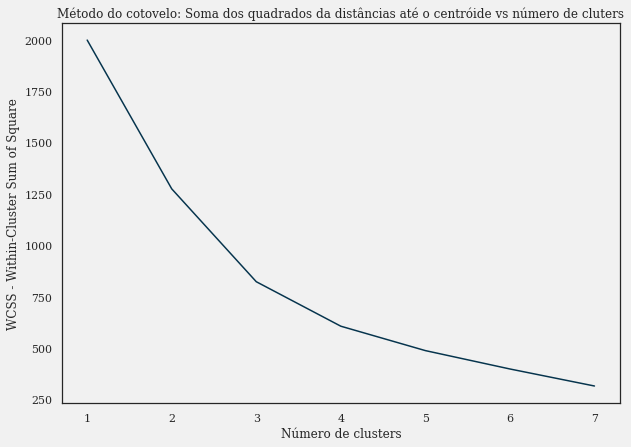

In [42]:
# classe para normalizar os dados
scaler = StandardScaler()
# df só com variáveis de acesso
df_acc = df[acc_var].copy()
# variáveis de acesso normalizadas
df_scaled = scaler.fit_transform(df_acc)

# WCSS - Within-Cluster Sum of Square
wcss = [] 
# método do cotovelo para encontrar o número ótimo de clusters
for i in range(1, 8): 
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_scaled) 
    wcss.append(kmeans.inertia_)

_,ax = plt.subplots(figsize=(10,7))
plt.plot(range(1, 8), wcss)
plt.xlabel('Número de clusters')
plt.ylabel('WCSS - Within-Cluster Sum of Square') 
plt.title('Método do cotovelo: Soma dos quadrados da distâncias até o centróide vs número de cluters')
plt.show()

Número ótimo de clusters segundo o método do cotovelo: 2.

Número de usuários por cluster:
User          661
Heavy User    338
Name: Cluster, dtype: int64


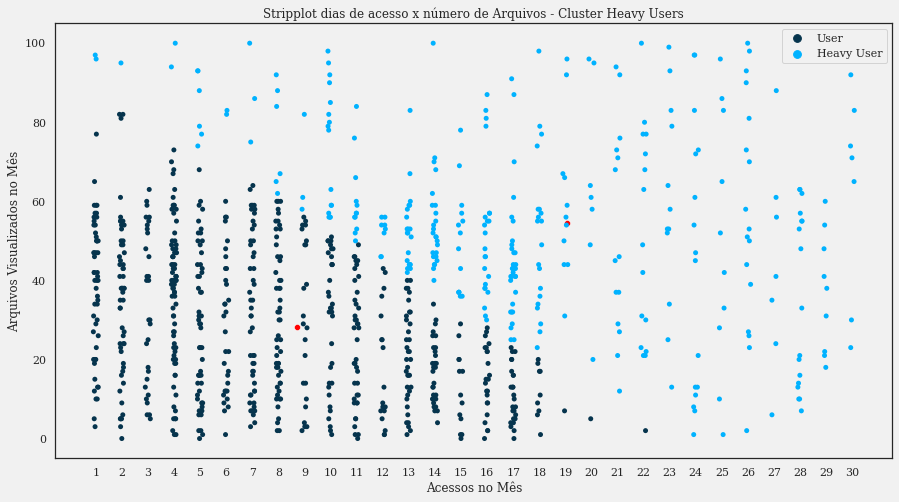

In [18]:
# classe para normalizar os dados
scaler = StandardScaler()
# df só com variáveis de acesso
df_acc = df[acc_var].copy()
# variáveis de acesso normalizadas
df_scaled = scaler.fit_transform(df_acc)

# clusters
kmeans = KMeans(n_clusters = 2, random_state = seed)

df_cluster = pp_pipe.fit_transform(df)
# adiciona uma coluna com o cluster do usuário
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# salva o artefato do kmeans  
#joblib.dump(kmeans, "kmeans_heavy_user.pkl")
# kmeans = joblib.load("kmeans_heavy_user.pkl") # carrega kmeans

df_cluster['Cluster'] = df_cluster['Cluster'].map({0:'Heavy User', 1:'User'})
# salva os centróides
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# printa quantos usuários tem em cada cluster
print(f"Número de usuários por cluster:\n{df_cluster['Cluster'].value_counts()}")

# plota stripplot dos usuários pelas variáveis de acesso e divididos por cluster
fig,ax=plt.subplots(figsize=(15,8))
sns.stripplot(x=df['Acessos no Mês'],y=df['Arquivos Visualizados no Mês'], 
              hue=df_cluster['Cluster'],
              ax=ax)
ax.set_title('Stripplot dias de acesso x número de Arquivos - Cluster Heavy Users')
# plota centróides dos clusters
sns.scatterplot(x=centers[:, 1], y=centers[:, 0], ax=ax, color='red',alpha=1)
plt.show()

A clusterização propõe uma boa divisão dos usuários por utilização da plataforma considerando dias de acesso e número de arquivos visualizados.

O cluster Heavy Users e é constituído por 338 usuários, aproximadamente um terço do dataset.

## Perfil do Heavy User

Vamos entender qual é a distribuição das outras variáveis desses usuários para traçar seu perfil:

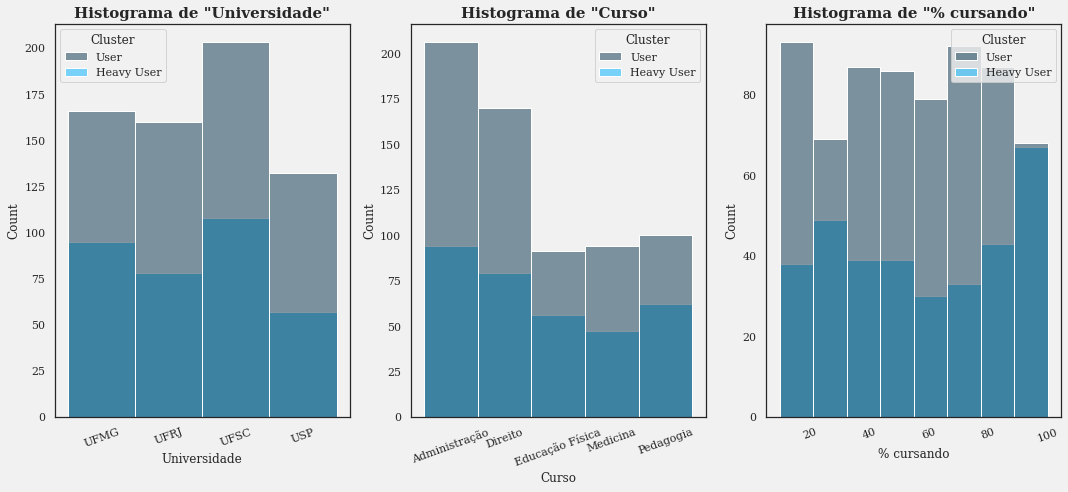

In [194]:
col_plot = ['Universidade', 'Curso', '% cursando']

# plota os hists
plot_hist(df=df_cluster,
          col_plot=col_plot, 
          rota=20,
          hue='Cluster', 
          figsize=(15,7),
          kde=False,
          nrows=1,
          ncols=3)

Quanto % dos Heavy Users são de cada curso: 
Curso
Administração      27.81
Direito            23.37
Educação Física    16.57
Medicina           13.91
Pedagogia          18.34
Name: Userid, dtype: float64

Quanto % de cada curso é Heavy User: 
Curso
Administração      31.0
Direito            32.0
Educação Física    38.0
Medicina           33.0
Pedagogia          38.0
Name: Userid, dtype: float64


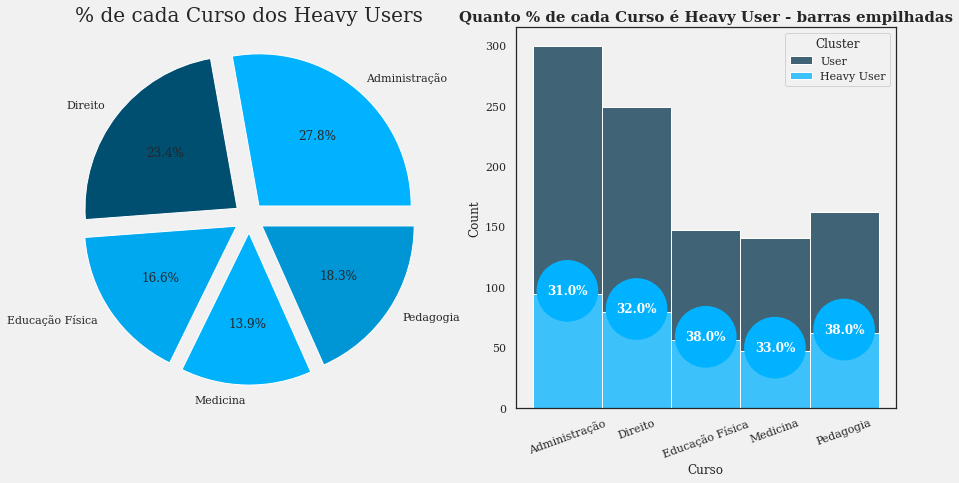

In [19]:
# CURSO
user_perfil(df_cluster,'Curso', hue='Cluster',hue_cond='Heavy User')

A maior parte dos Heavy users cursa Administração (27.8%) e a menor cursa Medicina (13.9%). Porém, Medicina tem uma proporção maior de Heavy users (31% vs 33%)

Pedagogia e Educação física são os cursos com maior proporção de Heavy users, apesar de terem menos Heavy users que Administração e Direito em números absolutos

Quanto % dos Heavy Users são de cada curso: 
Universidade
UFMG    28.11
UFRJ    23.08
UFSC    31.95
USP     16.86
Name: Userid, dtype: float64

Quanto % de cada curso é Heavy User: 
Universidade
UFMG    36.0
UFRJ    33.0
UFSC    35.0
USP     30.0
Name: Userid, dtype: float64


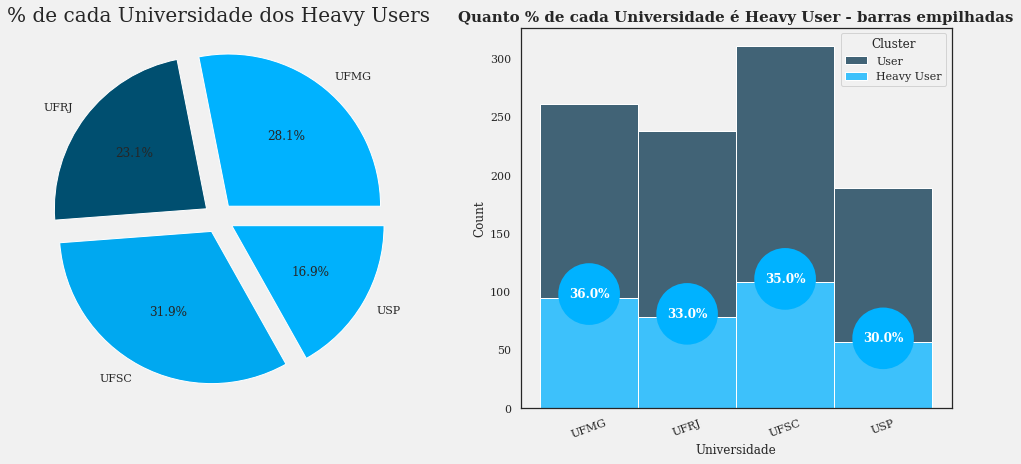

In [20]:
# UNIVERSIDADE
user_perfil(df_cluster,'Universidade', 
            hue='Cluster',
            hue_cond='Heavy User',
            figsize=(17,7))

A maior parte dos Heavy users cursa UFSC (31.9%) e a menor cursa USP (16.9%)

UFMG é a Universidade com maior proporção de Heavy users (36%) entre seus alunos, mas UFSC tem mais Heavy users em números absolutos 


Quanto % dos Heavy users estão no Semestre atual: 
Semestre Atual
1     10.36
2     13.61
3     11.54
4     11.83
5     10.06
6      8.88
7     12.13
8     17.46
9      2.66
10     1.48
Name: Userid, dtype: float64

Quanto % dos users do Semestre atual são Heavy users: 
Semestre Atual
1     29.0
2     41.0
3     31.0
4     31.0
5     30.0
6     24.0
7     32.0
8     47.0
9     75.0
10    50.0
Name: Userid, dtype: float64


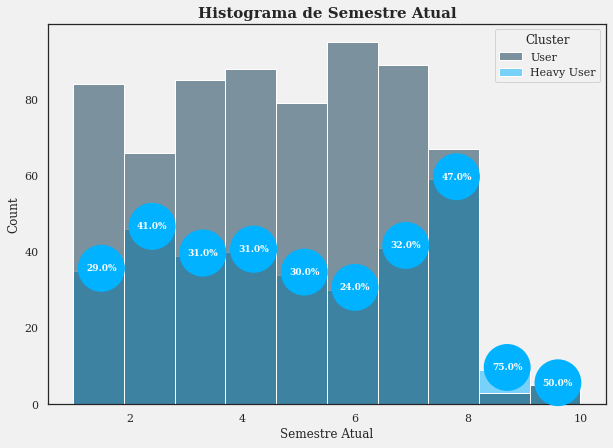

In [118]:
# df apenas com Heavy users
df_aux2 = df_cluster[df_cluster['Cluster']=='Heavy User'].copy()

# SEMESTRE ATUAL
print(f'\nQuanto % dos Heavy users estão no Semestre atual: \n'
      + f"{np.round(df_aux2.groupby(['Semestre Atual'])['Userid'].count()/len(df_aux2)*100,2)}")
print(f'\nQuanto % dos users do Semestre atual são Heavy users: \n'
      + f"{np.round(df_aux2.groupby(['Semestre Atual'])['Userid'].count()/df_avm.groupby(['Semestre Atual'])['Userid'].count(),2)*100}")

# plota histograma
_,ax=plt.subplots(figsize=(10,7))
sns.histplot(data=df_cluster, x='Semestre Atual',hue='Cluster', bins=10, ax=ax)
ax.set_title('Histograma de Semestre Atual', size=15, weight='bold')

# quantidade de usuários em cada semestre
data_count= df_aux2.groupby(['Semestre Atual'])['Userid'].count()
# % de quantos usuários de cada semestre são heavy users 
data_perc= np.round(df_aux2.groupby(['Semestre Atual'])['Userid'].count()/df_avm.groupby(['Semestre Atual'])['Userid'].count()*100,0)

# localização (eixo x) dos círculos com %
contador=[1.5,2.4,3.3,4.2,5.1,6,6.9,7.8,8.7,9.6]
# adiciona os círculos com %
for c, count, perc in zip(contador,data_count,data_perc):
  ax.text(x = c, y = count,
                  s = f'{perc}%', 
                  ha = 'center', size = 9, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))

47% dos estudantes do oitavo período são heavy users. 

Estudantes de Medicina no 9º e 10º tem períodos têm 75% e 50% dos usuários como Heavy users.

O 6º é o período com mais usuários na plataforma porém tem a menor proporção de Heavy users (24%)

No handles with labels found to put in legend.



Quanto % dos Heavy users são pagantes e não pagantes: 
Usuário Pagante?
0    34.32
1    65.68
Name: Userid, dtype: float64

Quanto % dos pagantes e não pagantes são Heavy users: 
Usuário Pagante?
0    17.0
1    67.0
Name: Userid, dtype: float64


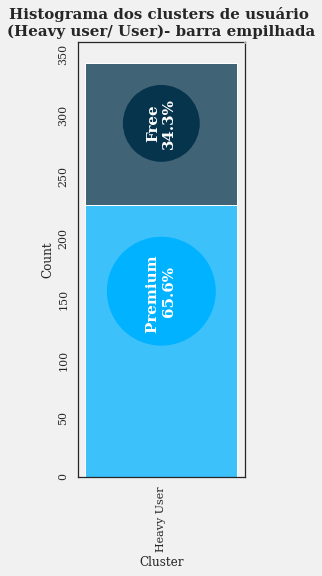

In [110]:
df_aux2 = df_cluster[df_cluster['Cluster']=='Heavy User'].copy()
target='Usuário Pagante?'
# PAGANTES
print(f'\nQuanto % dos Heavy users são pagantes e não pagantes: \n'
      + f"{np.round(df_aux2.groupby([target])['Userid'].count()/len(df_aux2)*100,2)}")
print(f'\nQuanto % dos pagantes e não pagantes são Heavy users: \n'
      + f"{np.round(df_aux2.groupby([target])['Userid'].count()/df_avm.groupby([target])['Userid'].count(),2)*100}")

data_pag = df_aux2.groupby([target])['Userid'].count()/len(df_aux2)*100
_,ax=plt.subplots(figsize=(3,8))
sns.histplot(data=df_aux2,
             x='Cluster', 
             hue=target,
             multiple='stack')

ax.set_title('Histograma dos clusters de usuário \n(Heavy user/ User)- barra empilhada',size=15, weight='bold')
# balão %
ax.text(x = 0, y = 120,
                  s = 'Premium \n65.6%', 
                  ha = 'center', size = 15, weight = 'bold', rotation = 90, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
ax.text(x = 0, y = 270,
                  s = 'Free\n34.3%', 
                  ha = 'center', size = 15, weight = 'bold', rotation = 90, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))

ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=90)
# omite a legenda
plt.legend(fontsize=1)

# Qual é o perfil predominante do usuário que assina (é pagante) a plataforma.


In [ ]:
df_aux = df1.copy()
df_aux['Universidade'] = df1['Universidade'].apply(lambda x: x.split()[0]).map(dic_uni)
df_aux['Curso'] = df_aux['Curso'].map(dic_curso)


algoritmo = SelectKBest(score_func=f_classif, k=6)
best_k_features = algoritmo.fit_transform(df_aux.drop(target,axis=1),df_aux[target])

scores_fclassif = pd.DataFrame(algoritmo.scores_,df_aux.drop(target,axis=1).columns)

#print results
print(scores_fclassif.sort_values(by=0, ascending=False).head(10))

                                         0
Acessos no Mês                2.502283e+02
Arquivos Visualizados no Mês  1.437363e+02
Semestre Atual                1.471886e+00
Universidade                  1.226081e+00
Curso                         2.168886e-13
Semestre Total                0.000000e+00


O teste f_classif indica que os dias acessados no mês são mais relevantes para o prever o usuário ser assinante que o número de arquivos acessados.

Quanto % dos Pagantes são de cada curso: 
Curso
Administração      30.03
Direito            24.92
Educação Física    14.71
Medicina           14.11
Pedagogia          16.22
Name: Userid, dtype: float64

Quanto % de cada curso é Pagante: 
Curso
Administração      33.0
Direito            33.0
Educação Física    33.0
Medicina           33.0
Pedagogia          33.0
Name: Userid, dtype: float64


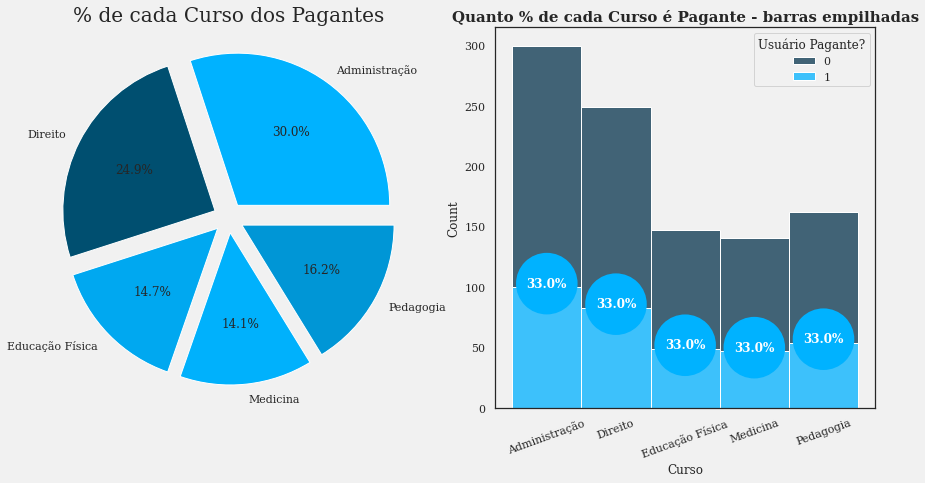

In [114]:
# CURSO
user_perfil(df_avm,'Curso', 
            hue='Usuário Pagante?',
            hue_cond=1,
            titulo = 'Pagante')

A maior parte dos pagantes cursa Administração (30%) e a menor cursa Medicina (14.1%).

33% dos usuários de todos os cursos são pagantes.

Quanto % dos Pagantes são de cada curso: 
Universidade
UFMG    29.13
UFRJ    23.42
UFSC    28.23
USP     19.22
Name: Userid, dtype: float64

Quanto % de cada curso é Pagante: 
Universidade
UFMG    37.0
UFRJ    33.0
UFSC    30.0
USP     34.0
Name: Userid, dtype: float64


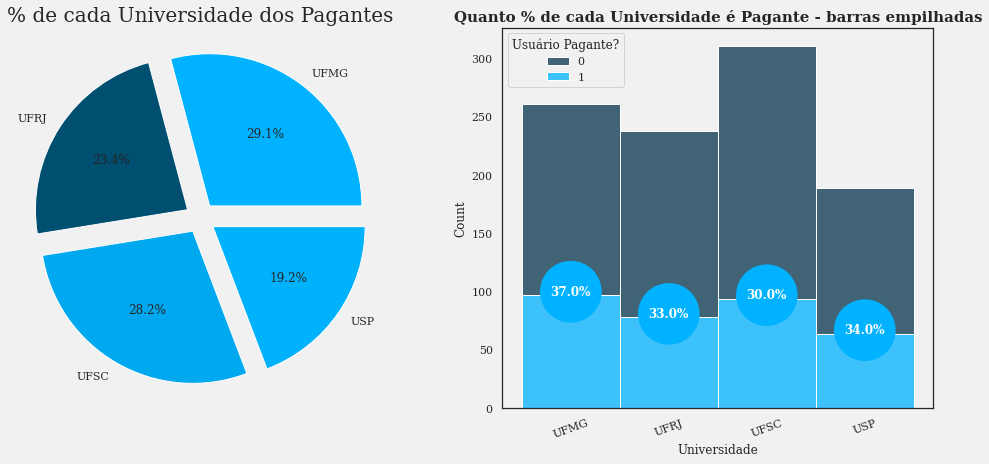

In [117]:
# UNIVERSIDADE
user_perfil(df_avm,'Universidade', 
            hue='Usuário Pagante?',
            hue_cond=1,
            titulo = 'Pagante',
            figsize=(17,7))

UFSC tem o maior número absoluto de usuários dentre as 4 universidades mas a menor proporção de usuários pagantes: apenas 30% dos estudantes da UFSC que acessam a plataforma são assinantes.

Apesar de ter mais usuários da UFSC no plataforma, o maior número de usuários pagantes pertence à UFMG.


Quanto % dos pagantes estão no Semestre atual: 
Semestre Atual
1     13.81
2     12.91
3     12.31
4     12.31
5     11.71
6      9.31
7     11.41
8     12.91
9      2.10
10     1.20
Name: Userid, dtype: float64

Quanto % dos users do Semestre atual são pagantes: 
Semestre Atual
1     39.0
2     38.0
3     33.0
4     32.0
5     35.0
6     25.0
7     29.0
8     34.0
9     58.0
10    40.0
Name: Userid, dtype: float64


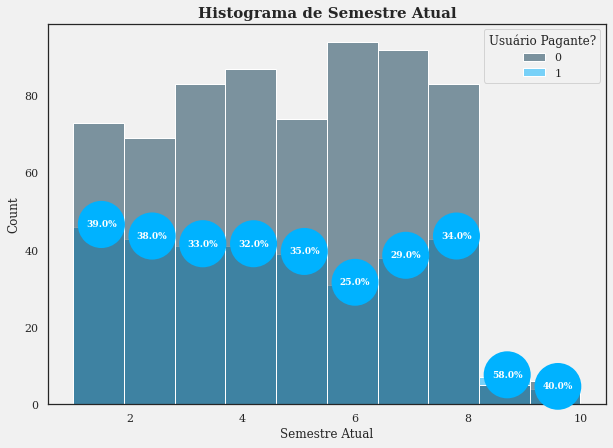

In [121]:
# df apenas com Heavy users
df_aux3 = df_cluster[df_cluster['Usuário Pagante?']==1].copy()

# SEMESTRE ATUAL
print(f'\nQuanto % dos pagantes estão no Semestre atual: \n'
      + f"{np.round(df_aux3.groupby(['Semestre Atual'])['Userid'].count()/len(df_aux3)*100,2)}")
print(f'\nQuanto % dos users do Semestre atual são pagantes: \n'
      + f"{np.round(df_aux3.groupby(['Semestre Atual'])['Userid'].count()/df_avm.groupby(['Semestre Atual'])['Userid'].count(),2)*100}")

# plota histograma
_,ax=plt.subplots(figsize=(10,7))
sns.histplot(data=df_cluster, x='Semestre Atual',hue='Usuário Pagante?', bins=10, ax=ax)
ax.set_title('Histograma de Semestre Atual', size=15, weight='bold')

# quantidade de usuários em cada semestre
data_count= df_aux3.groupby(['Semestre Atual'])['Userid'].count()
# % de quantos usuários de cada semestre são heavy users 
data_perc= np.round(df_aux3.groupby(['Semestre Atual'])['Userid'].count()/df_avm.groupby(['Semestre Atual'])['Userid'].count()*100,0)

# localização (eixo x) dos círculos com %
contador=[1.5,2.4,3.3,4.2,5.1,6,6.9,7.8,8.7,9.6]
# adiciona os círculos com %
for c, count, perc in zip(contador,data_count,data_perc):
  ax.text(x = c, y = count,
                  s = f'{perc}%', 
                  ha = 'center', size = 9, weight = 'bold', rotation = 0, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))

47% dos estudantes do oitavo período são pagantes. 

Desconsiderando o 9º e 10º período que tem poucas amostras, os dois primeiros períodos atraem maior proporção de assinantes.

O 6º é o período com mais usuários na plataforma porém tem a menor proporção de pagantes.

In [140]:
df_aux3.groupby([target])['Userid'].count()/len(df_aux3)*100

Cluster
Heavy User    66.666667
User          33.333333
Name: Userid, dtype: float64

No handles with labels found to put in legend.



Quanto % dos pagantes são Heavy Users: 
Cluster
Heavy User    66.67
User          33.33
Name: Userid, dtype: float64

Quanto % dos Heavy users são pagantes: 
Cluster
Heavy User    66.0
User          17.0
Name: Userid, dtype: float64


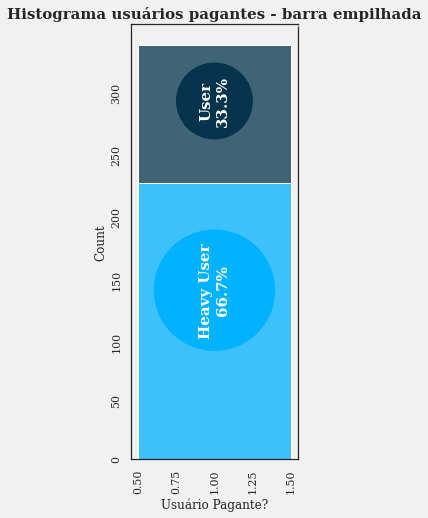

In [141]:
df_aux3 = df_cluster[df_cluster['Usuário Pagante?']==1].copy()
target = 'Cluster'
# PAGANTES
print(f'\nQuanto % dos pagantes são Heavy Users: \n'
      + f"{np.round(df_aux3.groupby([target])['Userid'].count()/len(df_aux3)*100,2)}")
print(f'\nQuanto % dos Heavy users são pagantes: \n'
      + f"{np.round(df_aux3.groupby([target])['Userid'].count()/df_cluster.groupby([target])['Userid'].count(),2)*100}")

data_pag = df_aux3.groupby([target])['Userid'].count()/len(df_aux3)*100
_,ax=plt.subplots(figsize=(3,8))
sns.histplot(data=df_aux3,
             x='Usuário Pagante?', 
             hue=target,
             multiple='stack')

ax.set_title('Histograma usuários pagantes - barra empilhada',size=15, weight='bold')
# balão %
ax.text(x = 1, y = 100,
                  s = 'Heavy User\n66.7%', 
                  ha = 'center', size = 15, weight = 'bold', rotation = 90, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[1], ec=colors[1], lw=2))
ax.text(x = 1, y = 270,
                  s = 'User\n33.3%', 
                  ha = 'center', size = 15, weight = 'bold', rotation = 90, color = 'white',
                  bbox=dict(boxstyle="circle,pad=0.8", fc= colors[0], ec=colors[0], lw=2))

ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=90)
# omite a legenda
plt.legend(fontsize=1)

In [122]:
Ddf_aux3 = df_avm[df_avm['Usuário Pagante?']== 1]
print('Para usuário pagantes \n')

print(f'Quanto % dos pagantes são de cada curso: \n'
      + f"{np.round(df_aux3.groupby(['Curso'])['Userid'].count()/len(df_aux3)*100,2)}")

print(f'\nQuanto % dos pagantes são de cada Universidade: \n'
      + f"{np.round(df_aux3.groupby(['Universidade'])['Userid'].count()/len(df_aux3)*100,2)}")

print(f'\nQuanto % dos pagantes são pagantes e não pagantes: \n'
      + f"{np.round(df_aux3.groupby([target])['Userid'].count()/len(df_aux3)*100,2)}")

print(f'\nQuanto % dos pagantes estão no Semestre atual: \n'
      + f"{np.round(df_aux3.groupby(['Semestre Atual'])['Userid'].count()/len(df_aux3)*100,2)}")



print(f'Quanto % de Cada curso é pagante: \n'
      + f"{np.round(df_aux3.groupby(['Curso'])['Userid'].count()/df.groupby(['Curso'])['Userid'].count(),2)*100}")

print(f'\nQuanto % de Cada Universidade é pagante: \n'
      + f"{np.round(df_aux3.groupby(['Universidade'])['Userid'].count()/df_avm.groupby(['Universidade'])['Userid'].count(),2)*100}")

print(f'\nQuanto % dos pagantes e não pagantes são pagante: \n'
      + f"{np.round(df_aux3.groupby([target])['Userid'].count()/df_avm.groupby([target])['Userid'].count(),2)*100}")

print(f'\nQuanto % dos users do Semestre atual são pagantes: \n'
      + f"{np.round(df_aux3.groupby(['Semestre Atual'])['Userid'].count()/df_avm.groupby(['Semestre Atual'])['Userid'].count(),2)*100}")

Para usuário pagantes 

Quanto % dos pagantes são de cada curso: 
Curso
Administração      30.03
Direito            24.92
Educação Física    14.71
Medicina           14.11
Pedagogia          16.22
Name: Userid, dtype: float64

Quanto % dos pagantes são de cada Universidade: 
Universidade
UFMG    29.13
UFRJ    23.42
UFSC    28.23
USP     19.22
Name: Userid, dtype: float64

Quanto % dos pagantes são pagantes e não pagantes: 
Usuário Pagante?
1    100.0
Name: Userid, dtype: float64

Quanto % dos pagantes estão no Semestre atual: 
Semestre Atual
1     13.81
2     12.91
3     12.31
4     12.31
5     11.71
6      9.31
7     11.41
8     12.91
9      2.10
10     1.20
Name: Userid, dtype: float64
Quanto % de Cada curso é pagante: 
Curso
Administração      33.0
Direito            33.0
Educação Física    33.0
Medicina           33.0
Pedagogia          33.0
Name: Userid, dtype: float64

Quanto % de Cada Universidade é pagante: 
Universidade
UFMG    37.0
UFRJ    33.0
UFSC    30.0
USP     34.0
Name:

Para entender quais materiais (curso e período) da plataforma têm mais valor para o usuário, um indício é a quantidade de usuários e assinantes cada curso tem em cada período.

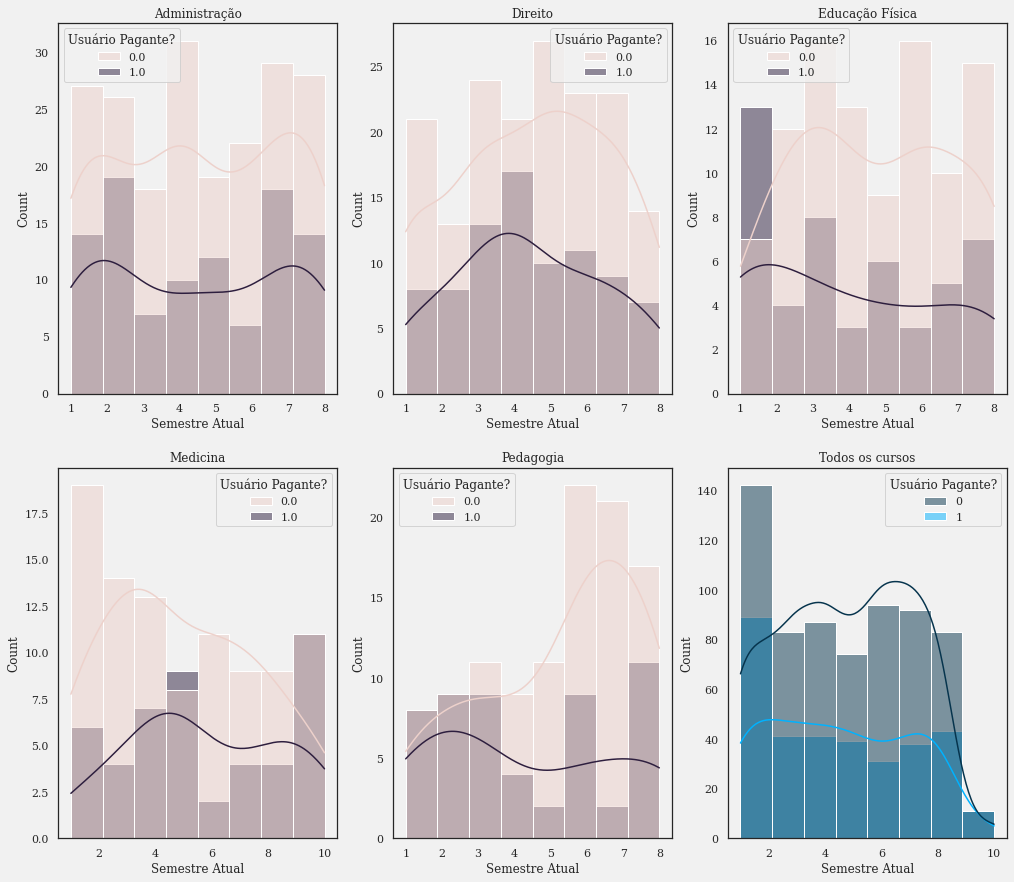

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(17,15))

# lista de cursos
cursos_plot = df.Curso.unique()
kde=True
# plota histograma sem medicina
for axis,curso in zip(ax.ravel(),cursos_plot):
  sns.histplot(data= df[df['Curso']==curso].copy(), x=df['Semestre Atual'],ax = axis, bins=8, hue=target,kde=kde)
  axis.set_title(f'{curso}')

sns.histplot(data=df, x=df['Semestre Atual'],ax = ax[1][2], bins=8, hue=target,kde=kde)
ax[1][2].set_title('Todos os cursos')
plt.show()

# Oportunidades

- 37% dos usuários da UFMG são assinantes. Ações para aumentar awereness/trial como trafego pago, ativações no campus e patrocínio de projetos estudantis aqui se aproveita da maior taxa de assinantes (conteúdo relevante para esse grupo) para minimizar o custo por assinante

- Dado que 30% da base cursa Administração, ações visando aumentar a relevância do material voltado a esse curso na plataforma tem potencial de aumentar a taxa de assinantes, maximizando o número absoluto desse.  
